# TP2: RNN

**Objetivo:**
    
Replicar sistema categorizador de productos de Mercado Libre, utilizando redes neuronales recurrentes.

**¿Por qué es importante un sistema así en un e-commerce?**

- Mejor sistema de búsqueda.
- Mayor confianza del usuario (permite completar mas atributos del producto de manera automática).
- Sistemas de recomendación más eficientes.
- Tomar acciones sobre una agrupación determinada de productos.

<img src="images/meli_vender.png" alt="drawing" width="700"/>

### Categorizador de dominios de Mercado Libre

**Documentación API Mercado Libre:**
    
https://developers.mercadolibre.com.ar/es_ar/categorias-y-atributos#Categorias

In [1]:
import http.client
from urllib.parse import quote_plus

In [2]:
conn = http.client.HTTPSConnection("api.mercadolibre.com")

In [3]:
title = "Taladro electrico percutor lusqtoff"

conn.request("GET", f"/sites/MLA/domain_discovery/search?q=${quote_plus(title)}")
res = conn.getresponse()
data = res.read()
print(data.decode("utf-8"))

[{"domain_id":"MLA-ELECTRIC_DRILLS","domain_name":"Taladros eléctricos","category_id":"MLA5232","category_name":"De Mano","attributes":[{"id":"BRAND","name":"Marca","value_id":"9775794","value_name":"Lüsqtoff"}]}]


## Generemos nuestro dataset

In [4]:
import pandas as pd
import json

In [5]:
conn.request("GET", "/sites/MLA/categories")
res = conn.getresponse()
data = res.read()
print(data.decode("utf-8"))

[{"id":"MLA5725","name":"Accesorios para Vehículos"},{"id":"MLA1512","name":"Agro"},{"id":"MLA1403","name":"Alimentos y Bebidas"},{"id":"MLA1071","name":"Animales y Mascotas"},{"id":"MLA1367","name":"Antigüedades y Colecciones"},{"id":"MLA1368","name":"Arte, Librería y Mercería"},{"id":"MLA1743","name":"Autos, Motos y Otros"},{"id":"MLA1384","name":"Bebés"},{"id":"MLA1246","name":"Belleza y Cuidado Personal"},{"id":"MLA1039","name":"Cámaras y Accesorios"},{"id":"MLA1051","name":"Celulares y Teléfonos"},{"id":"MLA1648","name":"Computación"},{"id":"MLA1144","name":"Consolas y Videojuegos"},{"id":"MLA1500","name":"Construcción"},{"id":"MLA1276","name":"Deportes y Fitness"},{"id":"MLA5726","name":"Electrodomésticos y Aires Ac."},{"id":"MLA1000","name":"Electrónica, Audio y Video"},{"id":"MLA2547","name":"Entradas para Eventos"},{"id":"MLA407134","name":"Herramientas"},{"id":"MLA1574","name":"Hogar, Muebles y Jardín"},{"id":"MLA1499","name":"Industrias y Oficinas"},{"id":"MLA1459","name":"I

In [6]:
pd.DataFrame(json.loads(data.decode("utf-8")))

,id,name
0,MLA5725,Accesorios para Vehículos
1,MLA1512,Agro
2,MLA1403,Alimentos y Bebidas
3,MLA1071,Animales y Mascotas
4,MLA1367,Antigüedades y Colecciones
5,MLA1368,"Arte, Librería y Mercería"
6,MLA1743,"Autos, Motos y Otros"
7,MLA1384,Bebés
8,MLA1246,Belleza y Cuidado Personal
9,MLA1039,Cámaras y Accesorios


In [7]:
from config import AppCfg

cfg = AppCfg()

class MeliGet:
    """
    Clase basica con fines de demostracion de uso.
    No recomendado para fines de obtener performance.
    """
    
    def __init__(self, cfg):
        self.conn = http.client.HTTPSConnection("api.mercadolibre.com")
        self.payload = ''
        self.headers = {
            'Bearer': cfg.ACCESS_TOKEN
        }
        
    def search_by_category(self, category_id, offset):
        try:
            self.conn.request(
                "GET", 
                f"/sites/MLA/search?category={category_id}&offset={offset}", 
                self.payload, 
                self.headers
            )
            res = self.conn.getresponse()
            data = res.read()
            df = pd.DataFrame(json.loads(data.decode("utf-8"))['results'])
        except:
            # print("DataFrame vacio.")
            df = pd.DataFrame([])
        return df
        
    def append_offset(self, category_id, n_offset):
        dfs = [self.search_by_category(category_id, offset) for offset in range(1, n_offset+1)]
        dfs = pd.concat(dfs).reset_index(drop=True)
        return dfs
    
    def build_dataset(self, category_list, n_offset):
        dfs = [self.append_offset(category_id, n_offset) for category_id in category_list]
        dfs = pd.concat(dfs).reset_index(drop=True)
        return dfs
        

In [8]:
meli = MeliGet(cfg)

In [9]:
tmp_df = meli.search_by_category('MLA1055', 1)

In [10]:
tmp_df.head(2)

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,...,catalog_listing,use_thumbnail_id,offer_score,offer_share,match_score,winner_item_id,melicoin,discounts,order_backend,differential_pricing
0,MLA1130114231,MLA,Samsung Galaxy A03 Core 32 Gb Black 2 Gb Ram,"{'id': 608846165, 'permalink': 'http://perfil....",27999,"{'id': 'MLA1130114231', 'prices': [{'id': '36'...",None,ARS,118,3139,...,True,True,None,None,None,None,None,None,1,NaN
1,MLA1132626332,MLA,Samsung Galaxy S21 Fe Lavanda 5g,"{'id': 608846165, 'permalink': 'http://perfil....",163999,"{'id': 'MLA1132626332', 'prices': [{'id': '117...",None,ARS,609,500,...,True,True,None,None,None,None,None,None,2,{'id': 35713248}


In [11]:
tmp_df.shape

(50, 39)

In [12]:
df = meli.build_dataset(['MLA1055', 'MLA1000', 'MLA1743', ], 50)

In [13]:
df.shape

(7500, 41)

In [14]:
df = df[['id', 'site_id', 'title', 'category_id', 'domain_id']]

In [15]:
df.to_csv('items_meli.csv', sep="␗", index=False)

### Read & clean data

In [27]:
import pandas as pd
import dask.dataframe as dd
from preprocessing import dask_proc

In [28]:
# !pip install textacy
# !dask_procinstall "dask[complete]"

In [56]:
df = pd.read_csv('items_meli.csv', sep="␗", engine='python')

In [58]:
df.head(3)

,id,site_id,title,category_id,domain_id
0,MLA915976815,MLA,Samsung Galaxy A02 32 Gb Negro 2 Gb Ram,MLA1055,MLA-CELLPHONES
1,MLA1105441801,MLA,Samsung Galaxy A12 64 Gb Azul 4 Gb Ram,MLA1055,MLA-CELLPHONES
2,MLA1112715843,MLA,Alcatel 3h 64 Gb Elegant Black 3 Gb Ram,MLA1055,MLA-CELLPHONES


In [59]:
tmp = dd.from_pandas(df, npartitions=5)

# Nombre de columna a preprocesar
title = 'title'

tmp = tmp.assign(title=tmp.map_partitions(dask_proc, title, meta='str')).compute(scheduler='processes')
tmp.title = tmp.title.astype('U')

In [60]:
df = tmp.copy()
del tmp

In [71]:
df.domain_id.nunique()

20

In [63]:
df.head(2)

,id,site_id,title,category_id,domain_id
0,MLA915976815,MLA,samsung galaxy a02 32 gb negro 2 gb ram,MLA1055,MLA-CELLPHONES
1,MLA1105441801,MLA,samsung galaxy a12 64 gb azul 4 gb ram,MLA1055,MLA-CELLPHONES


In [64]:
df.to_csv('items_meli_proc.csv', sep="␗", index=False)

### Labeling functions

In [80]:
import pandas as pd

In [81]:
# !pip install snorkel
# !pip install networkx==2.5.0

In [82]:
df = pd.read_csv('items_meli_proc.csv', sep="␗", engine='python')

In [83]:
df = df[df.domain_id.isin(['MLA-CELLPHONES', 'MLA-CELL_BATTERIES', 'MLA-SPEAKERS', 'MLA-HEADPHONES'])].reset_index(drop=True)

In [84]:
import re
from snorkel.labeling import labeling_function, PandasLFApplier

In [85]:
CELLPHONES = 0
CELL_BATTERIES = 1
SPEAKERS = 2
ABSTAIN = -1

In [86]:
df.sample(20)

,id,site_id,title,category_id,domain_id
1388,MLA915089577,MLA,celular lg k61 128gb liberado tienda oficial lg,MLA1055,MLA-CELLPHONES
3196,MLA832785930,MLA,auriculares audio technica m series ath m20x n...,MLA3697,MLA-HEADPHONES
1268,MLA923362790,MLA,samsung galaxy s20 fe 128 gb cloud navy 6 gb ram,MLA1055,MLA-CELLPHONES
3205,MLA634335872,MLA,blister 4 pilas aa recargables scp 2700 mah,MLA6384,MLA-CELL_BATTERIES
2567,MLA836361291,MLA,auriculares bluetooth f9 tws mejor que xiaomi ...,MLA3697,MLA-HEADPHONES
2830,MLA903069508,MLA,parlante jbl go 2 portatil con bluetooth midni...,MLA8618,MLA-SPEAKERS
1165,MLA925669757,MLA,samsung galaxy m12 dual sim 128gb 4 gb ram,MLA1055,MLA-CELLPHONES
3380,MLA727049560,MLA,auricular celular manos libres vincha extra ba...,MLA3697,MLA-HEADPHONES
670,MLA906108360,MLA,philco p241 dual sim 512 mb negro 256 mb ram,MLA1055,MLA-CELLPHONES
1444,MLA928360088,MLA,lg k51s 64gb 3gb titanium,MLA1055,MLA-CELLPHONES


In [87]:
@labeling_function()
def is_cellphone(x):
    return CELLPHONES if re.search(r"samsung|ram|dual sim|celular", x.title) else ABSTAIN

@labeling_function()
def is_cell_batteries(x):
    return CELL_BATTERIES if re.search(r"pila", x.title) else ABSTAIN

@labeling_function()
def is_speakers(x):
    return SPEAKERS if re.search(r"parlante", x.title) else ABSTAIN

In [88]:
lfs = [is_cellphone, is_cell_batteries, is_speakers]

In [89]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df[['title']])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3389/3389 [00:00<00:00, 23324.48it/s]


In [91]:
from snorkel.labeling import LFAnalysis


In [92]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()


,j,Polarity,Coverage,Overlaps,Conflicts
is_cellphone,0,[0],0.668339,0.0,0.0
is_cell_batteries,1,[1],0.036884,0.0,0.0
is_speakers,2,[2],0.082030,0.0,0.0


In [95]:
from snorkel.labeling.model import LabelModel

In [96]:
label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(L_train, seed=123, lr=0.01, log_freq=10, n_epochs=100)

In [97]:
label_model.cardinality

3

In [98]:
df["labels"] = label_model.predict(L_train)


In [101]:
df.head(2)

,id,site_id,title,category_id,domain_id,labels
0,MLA915976815,MLA,samsung galaxy a02 32 gb negro 2 gb ram,MLA1055,MLA-CELLPHONES,0
1,MLA1105441801,MLA,samsung galaxy a12 64 gb azul 4 gb ram,MLA1055,MLA-CELLPHONES,0


In [ ]:
df

### Model

In [102]:
import pandas as pd

In [103]:
df = pd.read_csv('items_meli_proc.csv', sep="␗", engine='python')

In [104]:
df = df[['title', 'domain_id']]

In [105]:
df = df[df.domain_id.isin(['MLA-CELLPHONES', 'MLA-HEADPHONES'])].reset_index(drop=True)

<AxesSubplot:>

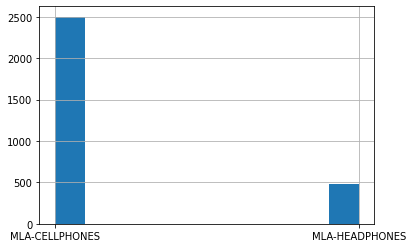

In [106]:
df.domain_id.hist()

In [107]:
df["domain_id"].replace({"MLA-CELLPHONES": 0, "MLA-HEADPHONES": 1}, inplace=True)

In [108]:
df.domain_id.unique()

array([0, 1])

In [20]:
df.to_csv('train.csv', index=False)